# The Complete Machine Learning

## Clasificación
En esta sección, pasamos de *predecir valores numéricos* (Regresión) a *predecir categorías* (Clasificación). Usaremos el famoso dataset **MNIST** (dígitos escritos a mano, del 0 al 9) para nuestros ejemplos.

### Regresión Logística (Logistic Regression)

* **¡Cuidado con el nombre!** A pesar de llamarse "regresión", es un modelo de **CLASIFICACIÓN**.
* **Qué es:** Un modelo lineal que estima la **probabilidad** de que una muestra pertenezca a una clase.
* **Cómo funciona:**
    1.  Calcula una puntuación lineal (igual que la regresión lineal: $a + b_1 x_1 + \dots$).
    2.  Pasa esa puntuación a través de una **función sigmoide (o logística)**. 
    3.  La función sigmoide "aplasta" cualquier valor a un resultado entre 0 y 1 (la probabilidad).
    4.  Para problemas con múltiples clases (como MNIST), usa técnicas como "Uno-vs-Resto" (OvR) o "Softmax" para gestionar las 10 clases.


In [14]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # ¡Importante!

# 1. Cargar datos (Esto puede tardar un poco la primera vez)
print("Cargando datos de MNIST...")
mnist = fetch_openml('mnist_784', as_frame=False, parser='liac-arff')
X, y = mnist["data"], mnist["target"]
print("Datos cargados.")

# 2. Dividir datos (Set original)
X_train_full, X_test_full = X[:60000], X[60000:]
y_train_full, y_test_full = y[:60000], y[60000:]

# --- ¡CORRECCIÓN DE VELOCIDAD! ---
# 3. Crear un subconjunto para ejecuciones rápidas
N_SAMPLES = 5000
X_train_subset = X_train_full[:N_SAMPLES]
y_train_subset = y_train_full[:N_SAMPLES]
# (Usaremos este subset para casi todo)

# 4. Crear el problema binario "Es un 5" (para el subset)
y_train_5_subset = (y_train_subset == '5')

# --- ¡CORRECCIÓN DE CONVERGENCIA Y VELOCIDAD! ---
# 5. Escalar los datos (¡Crucial para modelos lineales!)
scaler = StandardScaler()
# Entrenamos el scaler SÓLO con el subset
X_train_subset_scaled = scaler.fit_transform(X_train_subset.astype(np.float64))

# 6. Entrenar el modelo (Ahora sobre el subset escalado)
print("Entrenando LogisticRegression...")
log_reg = LogisticRegression(solver='saga', max_iter=1000, random_state=42, n_jobs=-1)
log_reg.fit(X_train_subset_scaled, y_train_5_subset) # Usando subset escalado
print("Entrenamiento completo.")

# 7. Predecir
# Tomamos el primer dígito (que es un 5) del SUBSET
some_digit = X_train_subset[0] 
# ¡Debemos escalar el dígito con el 'scaler' ya entrenado!
some_digit_scaled = scaler.transform([some_digit]) 

print(f"\nPredicción (clase): {log_reg.predict(some_digit_scaled)}")
print(f"Probabilidades [Prob_NO_5, Prob_SI_5]: {log_reg.predict_proba(some_digit_scaled)}")

Cargando datos de MNIST...
Datos cargados.
Entrenando LogisticRegression...
Entrenamiento completo.

Predicción (clase): [ True]
Probabilidades [Prob_NO_5, Prob_SI_5]: [[0.05814672 0.94185328]]


C:\Users\rodri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


    
### Clasificadores SGD (SGDClassifiers)

* **Qué es:** No es un modelo en sí mismo, sino un **optimizador** (`SGD` = Descenso de Gradiente Estocástico) aplicado a modelos lineales.
* **Cómo funciona:** `SGDClassifier` puede entrenar diferentes modelos (Regresión Logística, SVM Lineal) usando el optimizador SGD.
* **Sirve para:** Es extremadamente eficiente para **conjuntos de datos muy grandes (big data)** como MNIST, ya que procesa las muestras una por una o en pequeños lotes (batches), sin cargar toda la base de datos en memoria.


In [15]:
from sklearn.linear_model import SGDClassifier
# El 'scaler' ya fue creado y entrenado en la parte anterior

# 'loss="log_loss"' lo convierte en una Regresión Logística
sgd_clf = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=42, n_jobs=-1)

# Entrenamos sobre el subset escalado y el problema binario
sgd_clf.fit(X_train_subset_scaled, y_train_5_subset)

# Mostramos el modelo
sgd_clf

,loss,'log_loss'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,-1


### Matriz de Confusión (Confusion Matrix)

* **Qué es:** Una tabla que resume el rendimiento de un modelo comparando las predicciones con los valores reales. Es la base de todas las métricas de clasificación.
* **Estructura (para clasificación binaria):**
    * **Verdaderos Positivos (TP):** Real: 1, Pred: 1. (Acertó: Dijo "5" y *era* "5")
    * **Falsos Positivos (FP):** Real: 0, Pred: 1. (Falsa alarma: Dijo "5" pero *no era* "5")
    * **Falsos Negativos (FN):** Real: 1, Pred: 0. (Fallo: Dijo "No 5" pero *era* "5")
    * **Verdaderos Negativos (TN):** Real: 0, Pred: 0. (Acertó: Dijo "No 5" y *no era* "5")
* **Caso Multi-clase (MNIST):** La matriz se vuelve de 10x10.
    * La **diagonal principal** (de arriba-izq a abajo-der) muestra los **aciertos (TP)** para cada clase.
    * Los valores *fuera* de la diagonal son los **errores**.
    * *Interpretación:* Si la fila "Real: 7" y la columna "Pred: 9" tiene un 15, significa que el modelo confundió 15 sietes y dijo que eran nueves. 


Calculando predicciones multiclase (cross_val_predict)...
Cálculo finalizado.


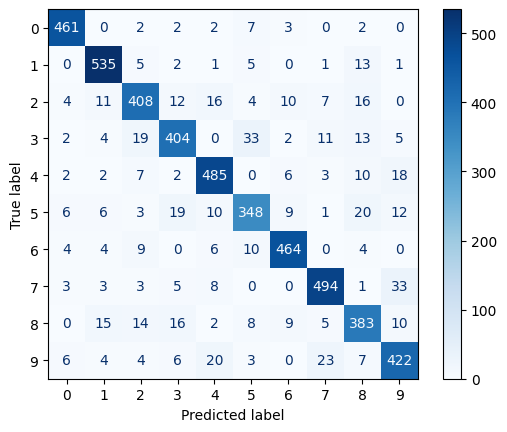

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

# 1. Definir un modelo multiclase
sgd_clf_multi = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42, n_jobs=-1)

# 2. Obtener predicciones (¡Usando el subset escalado y 'y' multiclase!)
print("Calculando predicciones multiclase (cross_val_predict)...")
y_train_pred_multi_subset = cross_val_predict(sgd_clf_multi, X_train_subset_scaled, y_train_subset, cv=3, n_jobs=-1)
print("Cálculo finalizado.")

# 3. Generar la matriz de confusión (10x10)
cm = confusion_matrix(y_train_subset, y_train_pred_multi_subset)

# 4. Visualizarla
# --- ¡CORRECCIÓN DE ERROR (ValueError)! ---
# Usamos np.unique() para obtener las etiquetas correctas (0-9) del subset
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train_subset))
disp.plot(cmap=plt.cm.Blues)
plt.show()



### Precisión (Precision)

* **Qué es:** Mide la exactitud de las predicciones *positivas*. De todas las veces que el modelo dijo "Positivo" (ej. "Es un 5"), ¿cuántas veces acertó?
* **Fórmula:** $\text{Precisión} = \frac{TP}{TP + FP}$
* **Cuándo es importante:** Cuando el coste de un **Falso Positivo (FP)** es alto. (Ej. Filtro de SPAM: No quieres que un email importante (FP) caiga en spam).


### Sensibilidad (Recall / Exhaustividad)

* **Qué es:** Mide la capacidad del modelo para *encontrar* todos los casos positivos. De todos los positivos *reales* (ej. todos los "5" reales), ¿cuántos encontró el modelo?
* **Fórmula:** $\text{Sensibilidad (Recall)} = \frac{TP}{TP + FN}$
* **Cuándo es importante:** Cuando el coste de un **Falso Negativo (FN)** es alto. (Ej. Diagnóstico de cáncer: No quieres "pasar por alto" a un paciente enfermo (FN)).


### Puntuación F1 (F1 Score)

* **Qué es:** La **media armónica** de la Precisión y la Sensibilidad.
* **Fórmula:** $F1 = 2 \times \frac{\text{Precisión} \times \text{Recall}}{\text{Precisión} + \text{Recall}}$
* **Sirve para:** Proporcionar una **métrica única** que equilibra ambas. Es la métrica estándar cuando se trabaja con **clases desbalanceadas** (ej. 99% "No Fraude", 1% "Fraude").


In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

# 1. Obtener predicciones para el problema binario "es 5" (¡Usando subset escalado!)
# Usamos el 'log_reg' que ya entrenamos en la celda 4
print("Calculando predicciones binarias (cross_val_predict)...")
y_train_pred_5_subset = cross_val_predict(log_reg, X_train_subset_scaled, y_train_5_subset, cv=3, n_jobs=-1)
print("Cálculo finalizado.")

# 2. Calcular métricas
prec = precision_score(y_train_5_subset, y_train_pred_5_subset, pos_label=True)
rec = recall_score(y_train_5_subset, y_train_pred_5_subset, pos_label=True)
f1 = f1_score(y_train_5_subset, y_train_pred_5_subset, pos_label=True)

print(f"\nPara la clase '5' (en el subset):")
print(f"  Precisión: {prec:.4f}")
print(f"  Recall: {rec:.4f}")
print(f"  Puntuación F1: {f1:.4f}")

# Para el caso MULTI-CLASE (usando las variables de la celda 8)
f1_multi = f1_score(y_train_subset, y_train_pred_multi_subset, average='weighted')
print(f"\nPuntuación F1 (promedio multi-clase, subset): {f1_multi:.4f}")

Calculando predicciones binarias (cross_val_predict)...
Cálculo finalizado.

Para la clase '5' (en el subset):
  Precisión: 0.7462
  Recall: 0.7857
  Puntuación F1: 0.7654

Puntuación F1 (promedio multi-clase, subset): 0.8804


### Compensación Precisión-Sensibilidad (Precision-Recall Tradeoff)

* **Qué es:** La relación inversa entre Precisión y Recall. **No se pueden tener ambas al 100%**. (Concepto para Clasificación Binaria).
* **Cómo funciona:** Los clasificadores (como Regresión Logística) no predicen `True` o `False` directamente; calculan una *puntuación (score)*.
    * El **Umbral (Threshold)** decide el corte (por defecto, 0.5 de prob. o 0 de score).
    * Si 📈 **aumentamos el umbral**: Seremos más exigentes para predecir `True`. Los `FP` bajarán (⬆️ Precisión), pero se nos "escaparán" más positivos (⬇️ Recall).
    * Si 📉 **disminuimos el umbral**: Seremos menos exigentes. Encontraremos más positivos (⬆️ Recall), pero también tendremos más falsas alarmas (⬇️ Precisión).
    ```python


Calculando scores (decision_function)...
Cálculo finalizado.


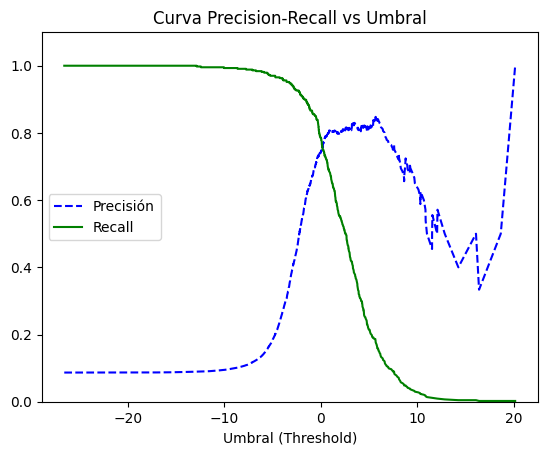

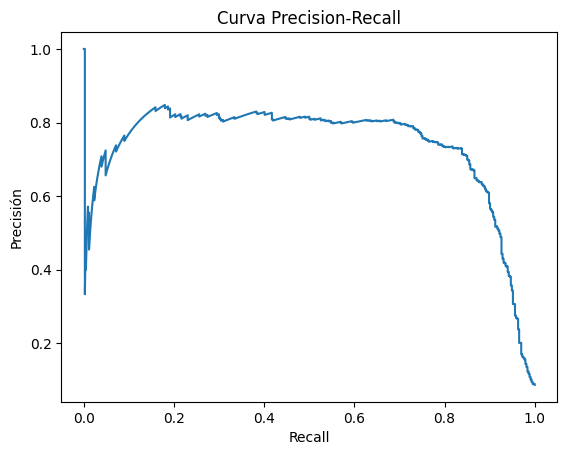

In [18]:
from sklearn.metrics import precision_recall_curve

# 1. Obtener los "scores" (¡Usando subset escalado!)
print("Calculando scores (decision_function)...")
y_scores_subset = cross_val_predict(log_reg, X_train_subset_scaled, y_train_5_subset, cv=3, 
                                    method="decision_function", n_jobs=-1)
print("Cálculo finalizado.")

# 2. Calcular los puntos de la curva
precisions, recalls, thresholds = precision_recall_curve(y_train_5_subset, y_scores_subset)

# 3. Graficar
plt.plot(thresholds, precisions[:-1], "b--", label="Precisión")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Umbral (Threshold)")
plt.legend()
plt.ylim([0, 1.1])
plt.title("Curva Precision-Recall vs Umbral")
plt.show()

# También se puede plotear Precisión vs Recall directamente
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precisión")
plt.title("Curva Precision-Recall")
plt.show()

### Curva ROC (ROC Curve)

* **Qué es:** Otra gráfica para evaluar el rendimiento de un clasificador binario a medida que se varía el umbral.
* **Ejes:**
    * **Eje Y: Tasa de Verdaderos Positivos (TPR)**. Es lo mismo que el **Recall**. $\frac{TP}{TP + FN}$
    * **Eje X: Tasa de Falsos Positivos (FPR)**. $\frac{FP}{FP + TN}$. Mide qué proporción de *negativos reales* fueron clasificados incorrectamente como positivos (falsas alarmas).
* **Interpretación:**
    * Un modelo perfecto estaría en la esquina superior izquierda (TPR=1, FPR=0).
    * Una línea diagonal (y=x) representa un clasificador aleatorio (inútil).
    * Cuanto más "arriba y a la izquierda" esté la curva, mejor es el modelo. 
* **AUC (Area Under the Curve):**
    * El **Área Bajo la Curva (AUC)** es la métrica clave. Es un número entre 0 y 1.
    * `AUC = 1`: Modelo perfecto.
    * `AUC = 0.5`: Modelo inútil (aleatorio).
* **Sirve para:** Evaluar el rendimiento *general* de un clasificador, independientemente del umbral elegido.


Área Bajo la Curva (AUC): 0.9576


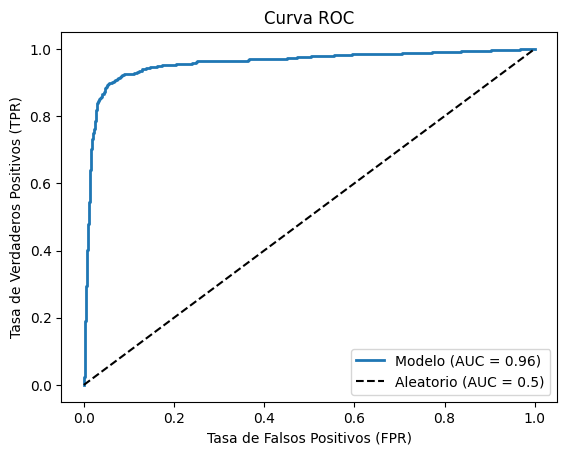

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score

# --- ¡CORRECCIÓN DE ERROR (NameError)! ---
# 1. Calcular puntos (usamos 'y_scores_subset' de la celda anterior)
# ¡Asegúrate de ejecutar la celda 14 antes que esta!
fpr, tpr, thresholds_roc = roc_curve(y_train_5_subset, y_scores_subset)

# 2. Calcular el AUC
auc_score = roc_auc_score(y_train_5_subset, y_scores_subset)
print(f"Área Bajo la Curva (AUC): {auc_score:.4f}")

# 3. Graficar
plt.plot(fpr, tpr, linewidth=2, label=f"Modelo (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Aleatorio (AUC = 0.5)") # Línea diagonal
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.legend(loc="lower right")
plt.title("Curva ROC")
plt.show()